<a href="https://colab.research.google.com/github/rajeshraj124/Deep-Learnig/blob/master/Jantahack_Image_Classinfication_Format.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setting Up Colab

In [171]:
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Download and Unzip Dataset

In [3]:
download = drive.CreateFile({'id': '1bXo5FaBLLywpYiMYm09PKu3IPXhNEt4k'})
download.GetContentFile('train_SOaYf6m.zip')
!unzip train_SOaYf6m.zip

Archive:  train_SOaYf6m.zip
   creating: images/
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         
  inflating: images/1018.jpg         
  inflating: images/1019.jpg         
 

##Importing Libraries

In [76]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, AveragePooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.applications.xception import Xception, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

##Loading DataSet

In [66]:
train = pd.read_csv('train.csv',dtype=str)


## Image Prepocessing

In [78]:
datagen = ImageDataGenerator(rotation_range=90,
                             rescale=1./ 255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range =0.2,
                             vertical_flip =True,
                             horizontal_flip = True,
                             fill_mode = 'nearest',
                             preprocessing_function = preprocess_input,
                             validation_split=0.25
                             )

In [79]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory='./images/',
x_col='image_names',
y_col='emergency_or_not',
subset='training',
batch_size=32,
seed=42,
shuffle=True,
class_mode='binary',
target_size=(224,224))
valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory='./images/',
x_col='image_names',
y_col='emergency_or_not',
subset='validation',
batch_size=32,
seed=42,
shuffle=True,
class_mode='binary',
target_size=(224,224))

Found 1235 validated image filenames belonging to 2 classes.
Found 411 validated image filenames belonging to 2 classes.


##Define the model structure

In [141]:
model_1 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

In [143]:
model_1.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [144]:
model_VGG16 = Sequential([
    model_1,GlobalAveragePooling2D(),
    Dense(1024,activation='relu'),
    Dense(512,activation='relu'),
    Dense(1,activation='sigmoid')
])

In [145]:
for layers in model_1.layers:
	layers.trainable=True

##Compile the model

In [146]:
lr_sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
lr_Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
lr_Adagrad=keras.optimizers.Adagrad(lr=0.0001, epsilon=1e-08, decay=0.0)
lr_Adadelta=keras.optimizers.Adadelta(lr=0.001, rho=0.95, epsilon=1e-08, decay=0.0)
lr_RMS = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)

model_VGG16.compile(loss = 'binary_crossentropy', optimizer = lr_Adam, metrics=['accuracy'])

##Training the model

In [147]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [148]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [149]:
epochs = 100
checkpoint_path = 'jantahackAV_Weight_3.h5'
keras_callbacks= [
      EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto'),
      ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
]
hist= model_VGG16.fit(train_generator,steps_per_epoch=STEP_SIZE_TRAIN,epochs=epochs,
                             validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,callbacks=keras_callbacks,class_weight=class_weights)
model_VGG16.save_weights('jantahackAV_Weight_Final_VGG16.h5')  # always save your weights after training or during training


Epoch 1/10
38/38 [==============================] - 21s 560ms/step - loss: 0.6618 - accuracy: 0.5869 - val_loss: 0.4438 - val_accuracy: 0.6745
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


38/38 [==============================] - 21s 541ms/step - loss: 0.5524 - accuracy: 0.7415 - val_loss: 0.5179 - val_accuracy: 0.7942
Epoch 3/10
38/38 [==============================] - 21s 542ms/step - loss: 0.5087 - accuracy: 0.7656 - val_loss: 0.5618 - val_accuracy: 0.6939
Epoch 4/10
38/38 [==============================] - 21s 542ms/step - loss: 0.4669 - accuracy: 0.7771 - val_loss: 0.4215 - val_accuracy: 0.8364
Epoch 5/10
38/38 [==============================] - 21s 540ms/step - loss: 0.4597 - accuracy: 0.7947 - val_loss: 0.4833 - val_accuracy: 0.7916
Epoch 6/10
38/38 [==============================] - 20s 534ms/step - loss: 0.4097 - accuracy: 0.8193 - val_loss: 0.3998 - val_accuracy: 0.8074
Epoch 7/10
38/38 [==============================] - 20s 529ms/step - loss: 0.4677 - accuracy: 0.7897 - val_loss: 0.4630 - val_accuracy: 0.8549
Epoch 8/10
38/38 [==============================] - 20s 515ms/step - loss: 0.3360 - accuracy: 0.8620 - val_loss: 0.3556 - val_accuracy: 0.8602
Epoch 9/10

##Plot Model accuracy and Loss


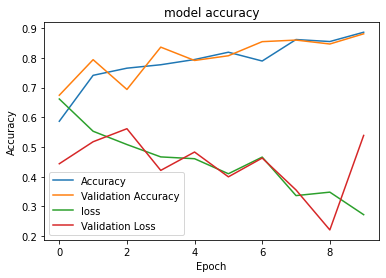

In [150]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy','loss','Validation Loss'])
plt.show()

##Save and Load Model

In [151]:
model_name = 'jantahack_av_model_VGG16.h5'
model_VGG16.save(model_name)

loaded_model =keras.models.load_model(model_name)

##Data Pre processing for Prediction

In [152]:
download = drive.CreateFile({'id': '1PMb_HEX4nirclDlz3HaZVHbBQaclEtCg'})
download.GetContentFile('sample_submission_yxjOnvz.csv')
test_file = pd.read_csv('sample_submission_yxjOnvz.csv',dtype=str)



##Making predictions


In [167]:
test_image = []
for i in tqdm(range(test_file.shape[0])):
    img = image.load_img('./images/'+test_file['image_names'][i], target_size=(224,224,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
test = np.array(test_image)

100%|██████████| 706/706 [00:00<00:00, 763.65it/s]


In [173]:
prediction=model_VGG16.predict_classes(test)

##Creating submission file


In [174]:
download = drive.CreateFile({'id': '1PMb_HEX4nirclDlz3HaZVHbBQaclEtCg'})
download.GetContentFile('sample_submission_yxjOnvz.csv')
sample = pd.read_csv('sample_submission_yxjOnvz.csv')
sample['image_names'] = test_file['image_names']
sample['emergency_or_not'] = prediction
sample.to_csv('sample.csv', header=True, index=False)